# Identificación de cobertura forestal 2022 en ocho municipios del sur de Yucatán


## 1. Introducción



## 2. Entorno computacional

Se importan diversas bibliotecas para análisis y visualización de datos geoespaciales, autenticándonos e inicializando la API de Google Earth Engine (GEE) para utilizar sus servicios.



![Modelo computacional de Google Earth Engine ](https://ars.els-cdn.com/content/image/1-s2.0-S0034425717302900-gr2.jpg)

del paper https://www.sciencedirect.com/science/article/pii/S0034425717302900

In [ ]:
import ee
import folium


import altair as alt
import eerepr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
import geemap.core as geemap
import seaborn as sns
# Autenticarse en la API de GEE
ee.Authenticate()

# Inicializar la libreria
ee.Initialize(project='321924100876')

## 3. Generación de funciones

Estas funciones permiten realizar clasificación de imágenes satelitales usando diferentes algoritmos de machine learning (RandomForest, GTB, SVM, Cart), validar el modelo obtenido y visualizar los resultados en un mapa. Se extraen valores de las bandas de un mosaico para el entrenamiento y validación, y se añaden capas de Google Earth Engine (GEE) a mapas folium para visualización interactiva.

In [ ]:
## Funciones

### Modelos de machine learning

def extrae_valores(mosaico,data,campo_id,bandas):
  data_sampling = mosaico.select(bandas).sampleRegions(collection=data,properties=[campo_id],scale=20)
  return data_sampling

def clasifica_mosaico(mosaico,data_training, tipo_class,campo_id,n_clases,bandas=['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']):
  ##Muestrear la región
  rf_training = mosaico.select(bandas).sampleRegions(
                            collection=data_training,
                              properties=[campo_id],
                              scale=20,
                                      )
  ## Distintos tipos de clasificadores
  if(tipo_class=='RandomForest'):
  ## Entrenar al clasificador
    rf = ee.Classifier.smileRandomForest(500).train( ##smileRandomForest
      features=rf_training,
      classProperty=campo_id,
      inputProperties= bandas
    )
    ## Extraer las probabilidades de los pixeles en lugar de solo la clasificación
    map_prob = ee.Classifier.smileRandomForest(500).setOutputMode('MULTIPROBABILITY').train(
    features = rf_training,
    classProperty =campo_id,
    inputProperties =bandas)
    ## Mosaico clasificado
    img_clas_rf= mosaico.select(bandas).classify(rf)
    probability = mosaico.classify(map_prob).multiply(100)
    return rf,img_clas_rf,probability


  if(tipo_class=='GTB'):
  ## Entrenar al clasificador
    gtb = ee.Classifier.smileGradientTreeBoost(100).train( ##smileRandomForest
      features=rf_training,
      classProperty=campo_id,
      inputProperties= bandas
    )
    map_prob = ee.Classifier.smileGradientTreeBoost(500).setOutputMode('MULTIPROBABILITY').train(
    features= rf_training,
    classProperty= campo_id,
    inputProperties= bandas)
    ## Mosaico clasificado
    img_clas_gtb= mosaico.select(bandas).classify(gtb)
    probability = mosaico.classify(map_prob).multiply(100)
    return gtb,img_clas_gtb,probability


  if(tipo_class=='SVM'):
  ## Entrenar al clasificador
    svm = ee.Classifier.libsvm().train( ## SVM
      features=rf_training,
      classProperty=campo_id,
      inputProperties= bandas
    )
    map_prob = ee.Classifier.libsvm().setOutputMode('MULTIPROBABILITY').train(
    features= rf_training,
    classProperty= campo_id,
    inputProperties= bandas)
    ## Mosaico clasificado
    img_clas_svm= mosaico.select(bandas).classify(svm)
    probability = mosaico.classify(map_prob).multiply(100)
    return svm,img_clas_svm,probability


  if(tipo_class=='Cart'):
  ## Entrenar al clasificador
    cart = ee.Classifier.smileCart().train( ##smileRandomForest
      features=rf_training,
      classProperty=campo_id,
      inputProperties= bandas
    )
    map_prob = ee.Classifier.smileCart().setOutputMode('MULTIPROBABILITY').train(
    features= rf_training,
    classProperty= campo_id,
    inputProperties= bandas)
    ## Mosaico clasificado
    img_clas_cart= mosaico.select(bandas).classify(cart)
    probability = mosaico.classify(map_prob).multiply(100)
    return cart,img_clas_cart,probability


def validacion_modelo(mosaico,data_validation,campo_id,model_trained,n_clases,bandas=['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']):
  # muestreo de bandas en los datos de validación
  validation = mosaico.select(bandas).sampleRegions(
    collection= data_validation,
    properties= [campo_id],
    scale=20,
    tileScale=16);

  validated_cob = validation.classify(model_trained);
  # Obtener la matriz de confusión
  mc_cob = validated_cob.errorMatrix(campo_id,"classification")
  return mc_cob


### Visualizacion
paleta_cob =[
    '#bd744f', # Agropecuario
    '#9b9b9b', # Urbano/Desprovisto
    '#31688e', # Forestal arboreo
     ]
def add_ee_layer(self, ee_object, vis_params, name):

    try:
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)

    except:
        print("Could not display {}".format(name))

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer
# Add custom basemaps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

## 4. Insumos

Se una máscara de municipios (zona de estudio) cargando los puntos de entrenamiento y validación para el modelo, además de crear un mosaico de imágenes satelitales seleccionadas manualmente y recortado a la zona de estudio para análisis posterior.

In [ ]:
# Máscara de municipios para extraer o recortar el mosaico satélital, ze es el acrónimo de Zona de Estudio
ze = ee.FeatureCollection("projects/ee-victorhdzgeo/assets/aa2024-2/insumos/mun_yuc_mg2020_utm16")
# Puntos de entrenamiento para el modelo incluye propiedades geométricas como coordenadas y un campo tabular respecto a la clase a la que corresponde
entrenamiento_2022 = ee.FeatureCollection("projects/ee-victorhdzgeo/assets/aa2024-2/insumos/datos_entrenamiento_2022")
# Puntos de validacion para los modelos
validacion_2022 = ee.FeatureCollection("projects/ee-victorhdzgeo/assets/aa2024-2/insumos/datos_validacion_2022")
## Imagenes selccionadas manualmente para formar el mosaico, estas imágenes cubren la zona de estudio y son de distinto fecha dado que en todo el año
## es muy complicado obtener una imagen sin nubosidad en la zona de estudio, la integración del mosaico, en caso de sobreposicion espacial, se utiliza la mediana perse del pixel i,j para obtener el valor.
mosaico_2022_mun = ee.ImageCollection(
    [ee.Image('COPERNICUS/S2_SR_HARMONIZED/20220114T162629_20220114T163157_T15QZC'),
ee.Image('COPERNICUS/S2_SR_HARMONIZED/20220114T162629_20220114T163157_T16QBG'),
ee.Image('COPERNICUS/S2_SR_HARMONIZED/20220124T162549_20220124T162707_T16QCJ'),
ee.Image('COPERNICUS/S2_SR_HARMONIZED/20220402T162841_20220402T163958_T15QZC'),
ee.Image('COPERNICUS/S2_SR_HARMONIZED/20221220T162709_20221220T163016_T15QZC'),
ee.Image('COPERNICUS/S2_SR_HARMONIZED/20220124T162549_20220124T162707_T16QCH'),
ee.Image('COPERNICUS/S2_SR_HARMONIZED/20220114T162629_20220114T163157_T16QBH')]).median().multiply(0.0001).clip(ze)
## centrado de mapa
lat, lon = 20.50, -89.00

## 5. Municipios

Se añaden las capas base "Google Satellite Hybrid" y "Google Maps" al mapa, y se agrega la capa de municipios (ze) con parámetros de visualización en color negro. Finalmente, se incluye un control de capas para permitir la selección de capas visibles y se muestra el mapa. Todo esto con el objetivo de tener los 8 municipios de estudio.

In [ ]:
# Municipios
lc_vis_params = {'color': 'black'}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(ze, lc_vis_params, 'Municipios')
my_map.add_child(folium.LayerControl())
display(my_map)

### 5.1 Mosaico satelital de los ocho municipios

In [ ]:
# Mosaico satelital de los ocho municipios
lc_vis_params = {'min': 0,'max': 0.3,'bands':['B4','B3','B2']}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(mosaico_2022_mun, lc_vis_params, 'Mosaico satelital 20222')
my_map.add_child(folium.LayerControl())
display(my_map)

## 6. Puntos de entrenamiento

se agrega un marcador para cada punto de entrenamiento, mostrando su clase y ID de clase correspondiente. Los marcadores se colorean según la clase: verde para "Forestal", naranja para "Agropecuario", y gris para "Desprovisto de vegetación / Urbano". Finalmente, se muestra el mapa con los marcadores de entrenamiento.

In [ ]:
# Puntos de entrenamiento

lc_vis_params = {'min': 0,'max': 0.3,'bands':['B4','B3','B2']}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(mosaico_2022_mun, lc_vis_params, 'Mosaico satelital 20222')
my_map.add_child(folium.LayerControl())
data_train_df = ee.data.computeFeatures({
    'expression': entrenamiento_2022,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
clases = data_train_df['clase'].unique()
lista_coords = [[point.xy[1][0],point.xy[0][0]]for point in data_train_df.geometry]
i=0
for p_train in lista_coords:
  if data_train_df.clase[i]=='Forestal':
    type_color='green'
  elif data_train_df.clase[i]=='Agropecuario':
    type_color='orange'
  elif data_train_df.clase[i]=='Deprovisto de vegetación / Urbano':
    type_color='gray'
  my_map.add_child(folium.Marker(location = p_train,
                            popup =

                            "Clase:" + str(data_train_df.clase[i]) + '<br>' +
                            "ID_CLASE: " + str(data_train_df.clase_id[i]),
                            icon = folium.Icon(color = "%s" % type_color)))
  i = i + 1
display(my_map)

## 7. Puntos de validación

se agregan marcadores para cada punto de validación, mostrando su clase y ID de clase correspondiente. Los marcadores se colorean según la clase: verde para "Forestal", naranja para "Agropecuario", y gris para "Desprovisto de vegetación / Urbano". Finalmente, se muestra el mapa con los marcadores de validación.

In [ ]:
# Puntos de validación
lc_vis_params = {'min': 0,'max': 0.3,'bands':['B4','B3','B2']}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(mosaico_2022_mun, lc_vis_params, 'Mosaico satelital 20222')
my_map.add_child(folium.LayerControl())
data_val_df = ee.data.computeFeatures({
    'expression': validacion_2022,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
clases = ['Agropecuario','Deprovisto de vegetación / Urbano','Forestal']
lista_coords = [[point.xy[1][0],point.xy[0][0]]for point in data_val_df.geometry]
i=0
for p_train in lista_coords:
  if data_val_df.clase[i]=='Forestal':
    type_color='green'
  elif data_val_df.clase[i]=='Agropecuario':
    type_color='orange'
  elif data_val_df.clase[i]=='Deprovisto de vegetación / Urbano':
    type_color='gray'
  my_map.add_child(folium.Marker(location = p_train,
                            popup =

                            "Clase: " + str(data_val_df.clase[i]) + '<br>' +
                            "ID_CLASE: " + str(data_val_df.clase_id[i]),
                            icon = folium.Icon(color = "%s" % type_color)))
  i = i + 1
display(my_map)

## 8. Análisis exploratorio de datos

### 8.1 Bandas espectrales

Se extraen los valores de las bandas espectrales (B2 a B12) para los puntos de entrenamiento utilizando la función `extrae_valores` y se almacenan en un DataFrame de Pandas `data_train_bandas_df`. Luego, se filtran los datos para quedarse únicamente con los puntos de entrenamiento correspondientes a la clase 'Forestal' (clase_id 3) en el DataFrame `data_train_forestal`. Finalmente, se crea un nuevo DataFrame `df` que contiene los valores de todas las bandas espectrales y la clase a la que pertenecen los puntos de entrenamiento.

In [ ]:
# Bandas espectrales
data_train_bandas= extrae_valores(mosaico_2022_mun,entrenamiento_2022,'clase_id',['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12'])
data_train_bandas_df = ee.data.computeFeatures({
    'expression': data_train_bandas,
    'fileFormat': 'PANDAS_DATAFRAME'
})
data_train_forestal = data_train_bandas_df[data_train_bandas_df['clase_id']==3].drop('geo', axis=1)
data_train_forestal
df = data_train_bandas_df.drop('geo', axis=1)
df['clase']=data_train_df['clase']
df

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,clase_id,clase
0,0.3201,0.21220,0.05760,0.0997,0.1091,0.1825,0.25700,0.2817,0.2970,0.3105,1,Agropecuario
1,0.4166,0.30635,0.09535,0.1173,0.1537,0.1820,0.19235,0.2119,0.2252,0.2358,1,Agropecuario
2,0.3010,0.22390,0.06470,0.0879,0.1123,0.1320,0.14620,0.1641,0.1688,0.1761,1,Agropecuario
3,0.3240,0.25120,0.04700,0.0613,0.1041,0.1210,0.12850,0.1392,0.1441,0.1541,1,Agropecuario
4,0.2946,0.18860,0.04900,0.0703,0.0912,0.1305,0.16200,0.1880,0.2050,0.2180,1,Agropecuario
...,...,...,...,...,...,...,...,...,...,...,...,...
547,0.1730,0.08060,0.02190,0.0355,0.0252,0.0686,0.19440,0.2337,0.2492,0.2731,3,Forestal
548,0.1563,0.07230,0.02000,0.0346,0.0241,0.0667,0.19510,0.2501,0.2501,0.2755,3,Forestal
549,0.1899,0.09500,0.02830,0.0434,0.0360,0.0781,0.18940,0.2302,0.2506,0.2710,3,Forestal
550,0.1645,0.06780,0.01760,0.0362,0.0196,0.0706,0.25120,0.3206,0.3319,0.3544,3,Forestal


### 8.2 Firmas espectrales por clase

Se crea un gráfico de coordenadas paralelas para visualizar la firma espectral de las clases en los datos de entrenamiento. Cada línea en el gráfico representa un punto de entrenamiento y las diferentes bandas espectrales (B2 a B12) se muestran en los ejes paralelos. Las líneas se colorearán según la clase a la que pertenecen, con la escala de colores que va desde agropecuario (1) hasta forestal (3).

In [ ]:
# Firma espectral por clase
# Clases: (1) Agropecuario, (2) Deprovisto de vegetación / urbano (3) Forestal
import plotly.express as px

fig = px.parallel_coordinates(df[['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','clase_id']], color="clase_id", labels={"clase": 'Clases'},
                             color_continuous_scale=px.colors.diverging.Tealrose_r,
                             color_continuous_midpoint=2)
fig.show()

Mayor rango de valores para las bandas B11 y B12 en la categoria de Agricultura, a diferencia de los valores bajos para la categoria 3 (Forestal).

respecto a nuestra categoria de mayor interes, Forestal podemos ver la firma espectral con mayores valores en las bandas B6, B7, B8 B8A, en ninguno de las bandas parece superar un valor $> 0.4$  

### 8.3 Matriz de dispersión

Se crea una matriz de dispersión para visualizar la relación entre las diferentes bandas espectrales (B2 a B12) en los datos de entrenamiento. Cada punto en la matriz representa un punto de entrenamiento y la interacción entre las bandas se muestra en las diferentes celdas de la matriz. Los puntos se colorean según la clase a la que pertenecen. La diagonal principal se oculta para evitar la redundancia en la visualización. La matriz de dispersión permite identificar patrones y relaciones entre las bandas espectrales para cada clase de cobertura.

In [ ]:
# Matriz de dispersión
fig = px.scatter_matrix(df,
    dimensions=['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12'],
    color="clase",color_continuous_scale=px.colors.diverging.Tealrose_r)
fig.update_traces(diagonal_visible=False)
fig.update_layout(
    title='Valores de las bandas espectrales respecto a las categorias de cobertura',
    dragmode='select',
    width=1800,
    height=1800,
    hovermode='closest',
)
fig.show()

### 8.4 Matriz de correlación de B4,B8, B8A, B11 y B12

Se crea una matriz de dispersión para visualizar la relación entre las bandas espectrales B4, B8, B8A, B11 y B12 en los datos de entrenamiento. Cada punto en la matriz representa un punto de entrenamiento y la interacción entre las bandas se muestra en las diferentes celdas de la matriz. Los puntos se colorean según la clase a la que pertenecen. La diagonal principal se oculta para evitar la redundancia en la visualización. La matriz de dispersión permite identificar patrones y relaciones específicas entre estas bandas espectrales para cada clase de cobertura.

In [ ]:
# Matriz de correlación de B4,B8, B8A, B11 y B12
fig = px.scatter_matrix(df,
    dimensions=['B4','B8','B8A','B11','B12'],
    color="clase",color_continuous_scale=px.colors.diverging.Tealrose_r)
fig.update_traces(diagonal_visible=False)
fig.update_layout(
    title='Valores de las bandas espectrales respecto a las categorias de cobertura',
    dragmode='select',
    width=1800,
    height=1800,
    hovermode='closest',
)
fig.show()

### 8.5 Matriz de correlación para la clase de cobertura forestal

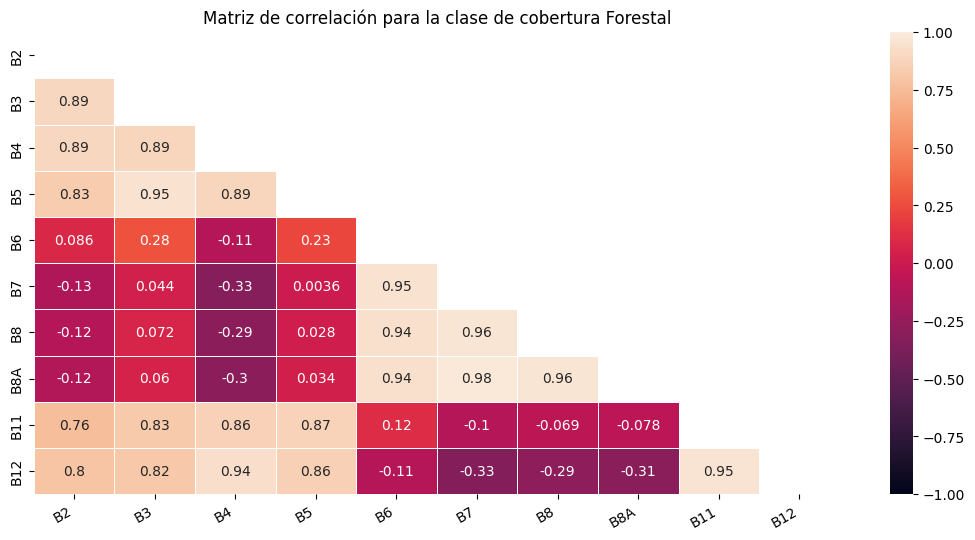

In [ ]:
# Matriz de correlación clase: Forestal
df_matrix = df[['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','clase_id','clase']].copy()
corr_mat_forest = df_matrix[df_matrix['clase_id']==3][list(df_matrix.columns)[:-2]].corr()
mask = np.triu(np.ones_like(corr_mat_forest, dtype=bool))
plt.figure(figsize=(13, 6))
sns.heatmap(corr_mat_forest, vmin=-1,vmax=1, annot=True, linewidths=.5,mask=mask)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Matriz de correlación para la clase de cobertura Forestal")
plt.show()

### 8.6 Matriz de correlación clase: Desprovisto de Vegetación / Urbano

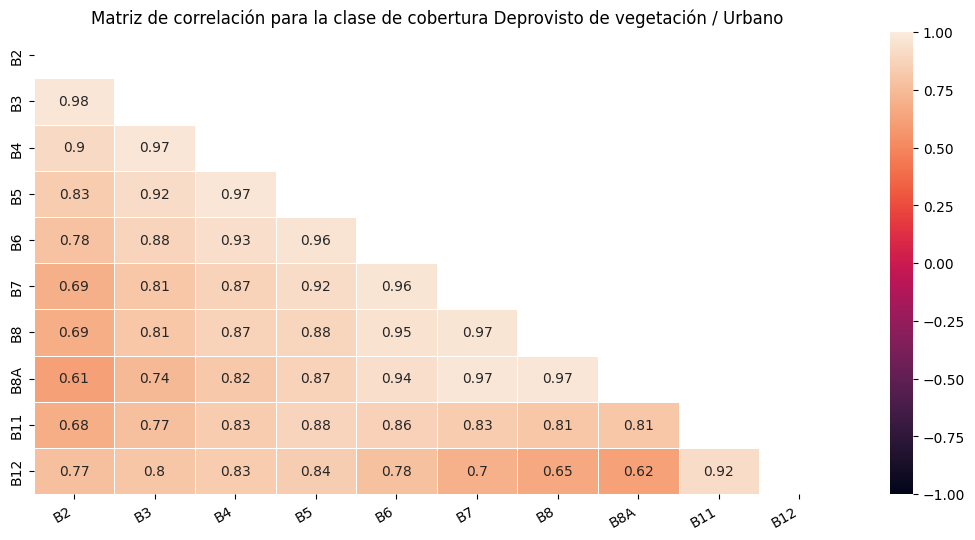

In [ ]:
# Matriz de correlación clase: Deprovisto de vegetación / Urbano
df_matrix = df[['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','clase_id','clase']].copy()
corr_mat_forest = df_matrix[df_matrix['clase_id']==2][list(df_matrix.columns)[:-2]].corr()
mask = np.triu(np.ones_like(corr_mat_forest, dtype=bool))
plt.figure(figsize=(13, 6))
sns.heatmap(corr_mat_forest, vmax=1, annot=True, linewidths=.5,mask=mask,vmin=-1)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Matriz de correlación para la clase de cobertura Deprovisto de vegetación / Urbano")
plt.show()

### 8.7 Matriz de correlación clase Agropecuario

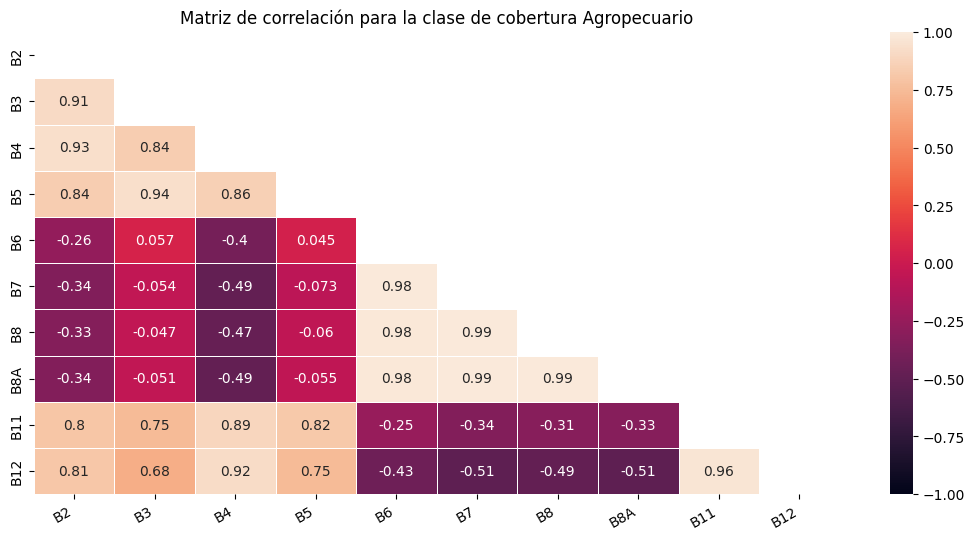

In [ ]:
# Matriz de correlación clase: Agropecuario

df_matrix = df[['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','clase_id','clase']].copy()
corr_mat_forest = df_matrix[df_matrix['clase_id']==1][list(df_matrix.columns)[:-2]].corr()
mask = np.triu(np.ones_like(corr_mat_forest, dtype=bool))
plt.figure(figsize=(13, 6))
sns.heatmap(corr_mat_forest, vmin=-1,vmax=1, annot=True, linewidths=.5,mask=mask)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Matriz de correlación para la clase de cobertura Agropecuario")
plt.show()

### 8.8 Exploración de NDVI y SAVI como variables latentes

Primero se calcula el Índice de Vegetación de Diferencia Normalizada (NDVI) para el mosaico satelital de 2022 y lo visualiza en un mapa. El NDVI se calcula como la diferencia normalizada entre las bandas del infrarrojo cercano (NIR) y el rojo (RED) de la imagen, utilizando la fórmula NDVI = (NIR - RED) / (NIR + RED). El mapa muestra el NDVI con una paleta de colores que va desde azul oscuro (valores bajos de NDVI, menos vegetación) hasta verde oscuro (valores altos de NDVI, más vegetación), pasando por tonos de marrón y amarillo que representan valores intermedios.

Después, se calcula el Índice de Vegetación Ajustado al Suelo (SAVI) para el mosaico satelital de 2022 y lo visualiza en un mapa. El SAVI es similar al NDVI, pero está ajustado para compensar la influencia del suelo. Se calcula como SAVI = ((NIR - RED) / (NIR + RED + L)) * (1 + L), donde NIR es la banda del infrarrojo cercano (B8), RED es la banda del rojo (B4) y L es un factor de ajuste (en este caso, se utiliza L=0.3). El mapa muestra el SAVI con una paleta de colores que va desde azul oscuro (valores bajos de SAVI) hasta verde oscuro (valores altos de SAVI), pasando por tonos intermedios que representan valores intermedios.

In [ ]:
#@title  NDVI Normalized Difference Vegetation Index
#@markdown $NDVI = \frac{NIR-RED}{NIR+RED}$
#@markdown ; Donde $NIR=B8$ y $RED=B4$
NDVI = mosaico_2022_mun.normalizedDifference(['B8','B4']).rename('NDVI').select('NDVI')

lc_vis_params = {'min': -1,'max': 1,'bands':['NDVI'],'palette': ['#0000ff', 'DF923D', 'F1B555',
    'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401',
    '056201', '004C00', '023B01', '012E01', '011D01', '011301']}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(NDVI, lc_vis_params, 'NDVI')
display(my_map)

In [ ]:
# @title  SAVI Soil Adjusted Vegetation Index
#@markdown $SAVI = \frac{NIR-RED}{NIR+RED+L}*(1-L)$
#@markdown ; Donde $NIR=B8$ , $RED=B4$ ,$L=0.5$
nir = mosaico_2022_mun.select('B8')
red = mosaico_2022_mun.select('B4')
L=0.3
SAVI_ = nir.subtract(red).divide(nir.add(red).add(L))
SAVI = SAVI_.multiply(1-L).rename('SAVI')
lc_vis_params = {'min': -1,'max': 1,'palette': ['#0000ff', 'DF923D', 'F1B555',
    'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401',
    '056201', '004C00', '023B01', '012E01', '011D01', '011301']}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(SAVI, lc_vis_params, 'SAVI')
display(my_map)
SAVI.max(SAVI)

Respecto a los índices NDVI y SAVI se tomo la decisión de no seguir explorando este camino, ya que los indices no muestran una gran varibabilidad para todas las clases y no mejorará al entrenamiento del modelo

## 9. Fase de entrenamiento y Resultados



## 9.1 Random Forest

Configuración y entrenamiento de un modelo de Random Forest (RF) para clasificar un mosaico de imágenes satelitales y almacenando los resultados del modelo entrenado y sus probabilidades.

In [ ]:
# Random Forest

modelos = {'modelo':[],'Accuracy':[],'Kappa':[]}

model_selected ='RandomForest'
model_trained_rf,cob_rf_map_2022,cob_rf_map_2022_prob =  clasifica_mosaico(mosaico_2022_mun,entrenamiento_2022,model_selected,'clase_id',3)

### 9.1.1 Matriz de confusión, accuracy e índice Kappa (RF)

Validación del modelo Random Forest mediante una matriz de confusión, calculando la precisión y el índice Kappa, y visualizando la matriz de confusión con un mapa de calor.

Con el modelo RandomForest se obtiene un accuracy de 0.918 y un índice de Kappa de 0.862


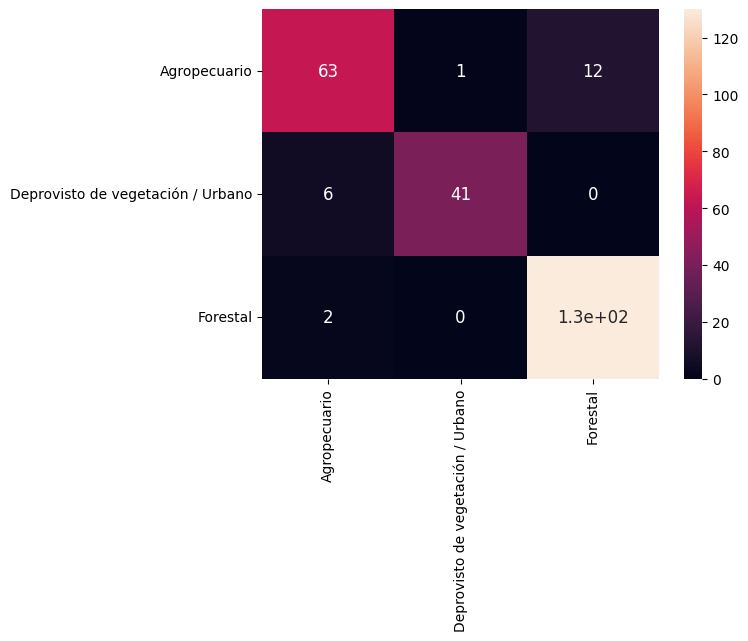

In [ ]:
# RF: Matriz de confusión, accuracy e índice Kappa
error_matrix = validacion_modelo(mosaico_2022_mun,validacion_2022,'clase_id',model_trained_rf,3)
accuracy = round(error_matrix.accuracy().getInfo(),3)
kappa = round(error_matrix.kappa().getInfo(),3)
modelos['modelo'].append(model_selected)
modelos['Accuracy'].append(accuracy)
modelos['Kappa'].append(kappa)
print(f'Con el modelo {model_selected} se obtiene un accuracy de {accuracy} y un índice de Kappa de {kappa}')
df_mc= pd.DataFrame(np.array(error_matrix.getInfo())[1:,1:],index=clases,columns=clases)
sns.heatmap(df_mc, annot=True, annot_kws={"size": 12}) # font size
plt.show()

### 9.1.2 Mapa de cobertura (RF)

In [ ]:
# RF: mapa de cobertura
lc_vis_params = {'min': 0,'max': 0.3,'bands':['B4','B3','B2']}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(mosaico_2022_mun, lc_vis_params, 'Mosaico satelital 20222')
lc_vis_params = {'min':1,'max':3,'palette':paleta_cob}
my_map.add_ee_layer(cob_rf_map_2022, lc_vis_params, f'Mapa de cobertura 2022 - {model_selected}')

my_map.add_child(folium.LayerControl())

display(my_map)

## 9.2 Gradient Tree Boost (GTB)

Configuración y entrenamiento del modelo de Gradient Tree Boost para clasificar el mosaico de imágenes satelitales y almacenar los resultados del modelo entrenado y sus probabilidades.

In [ ]:
#  Gradient Tree Boost
model_selected ='GTB'
model_trained_gtb,cob_gtb_map_2022,cob_gtb_map_2022_prob =  clasifica_mosaico(mosaico_2022_mun,entrenamiento_2022,model_selected,'clase_id',3)



### 9.2.1 Matriz de confusión, accuracy e índice Kappa (GTB)

Con el modelo GTB se obtiene un accuracy de 0.925 y un índice de Kappa de 0.875


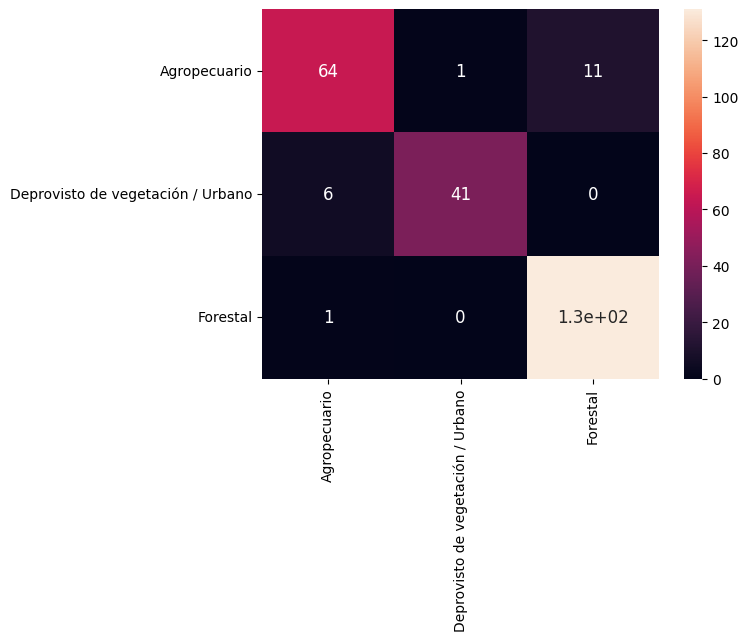

In [ ]:
# GTB: Matriz de confusión, accuracy e índice Kappa
error_matrix= validacion_modelo(mosaico_2022_mun,validacion_2022,'clase_id',model_trained_gtb,3)
accuracy = round(error_matrix.accuracy().getInfo(),3)
kappa = round(error_matrix.kappa().getInfo(),3)
modelos['modelo'].append(model_selected)
modelos['Accuracy'].append(accuracy)
modelos['Kappa'].append(kappa)
print(f'Con el modelo {model_selected} se obtiene un accuracy de {accuracy} y un índice de Kappa de {kappa}')
df_mc= pd.DataFrame(np.array(error_matrix.getInfo())[1:,1:],index=clases,columns=clases)
sns.heatmap(df_mc, annot=True, annot_kws={"size": 12}) # font size
plt.show()

### 9.2.2 Mapa de cobertura (GTB)

In [ ]:
# Mapa de cobertura (GTB)
lc_vis_params = {'min': 0,'max': 0.3,'bands':['B4','B3','B2']}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(mosaico_2022_mun, lc_vis_params, 'Mosaico satelital 20222')
lc_vis_params = {'min':1,'max':3,'palette':paleta_cob}
my_map.add_ee_layer(cob_gtb_map_2022, lc_vis_params, f'Mapa de cobertura 2022 - {model_selected}')

my_map.add_child(folium.LayerControl())

display(my_map)

## 9.3 Support Vector Machine (SVM)

In [ ]:
# Support Vector Machine (SVM)
model_selected ='SVM'
model_trained_svm,cob_svm_map_2022,cob_svm_map_2022_prob =  clasifica_mosaico(mosaico_2022_mun,entrenamiento_2022,model_selected,'clase_id',3)

### 9.3.1 Matriz de confusión, accuracy e índice Kappa (SVM)

Con el modelo SVM se obtiene un accuracy de 0.831 y un índice de Kappa de 0.708


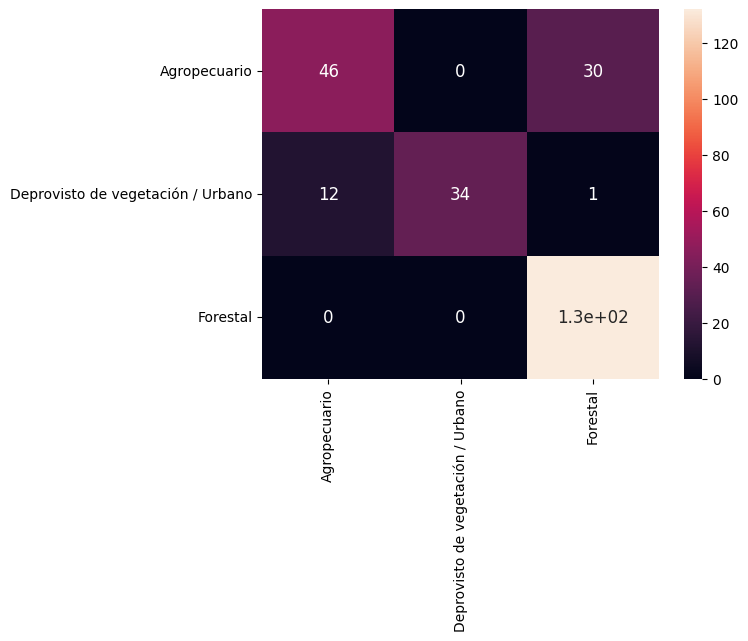

In [ ]:
# SVM: Matriz de confusión, accuracy e índice Kappa
error_matrix= validacion_modelo(mosaico_2022_mun,validacion_2022,'clase_id',model_trained_svm,3)
accuracy = round(error_matrix.accuracy().getInfo(),3)
kappa = round(error_matrix.kappa().getInfo(),3)
modelos['modelo'].append(model_selected)
modelos['Accuracy'].append(accuracy)
modelos['Kappa'].append(kappa)
print(f'Con el modelo {model_selected} se obtiene un accuracy de {accuracy} y un índice de Kappa de {kappa}')
df_mc= pd.DataFrame(np.array(error_matrix.getInfo())[1:,1:],index=clases,columns=clases)
sns.heatmap(df_mc, annot=True, annot_kws={"size": 12}) # font size
plt.show()

### 9.3.2 Mapa de cobertura (SVM)

In [ ]:
# SVM: mapa de cobertura
lc_vis_params = {'min': 0,'max': 0.3,'bands':['B4','B3','B2']}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(mosaico_2022_mun, lc_vis_params, 'Mosaico satelital 20222')
lc_vis_params = {'min':1,'max':3,'palette':paleta_cob}
my_map.add_ee_layer(cob_svm_map_2022, lc_vis_params, f'Mapa de cobertura 2022 - {model_selected}')

my_map.add_child(folium.LayerControl())

display(my_map)

## 9.4 Classification and Regression Trees (CART)

In [ ]:
# CART (Classification and Regression Trees)
model_selected ='Cart'
model_trained_cart,cob_cart_map_2022,cob_cart_map_2022_prob =  clasifica_mosaico(mosaico_2022_mun,entrenamiento_2022,model_selected,'clase_id',3)

### 9.4.1 Matriz de confusión, accuracy e índice Kappa (CART)

Con el modelo Cart se obtiene un accuracy de 0.89 y un índice de Kappa de 0.818


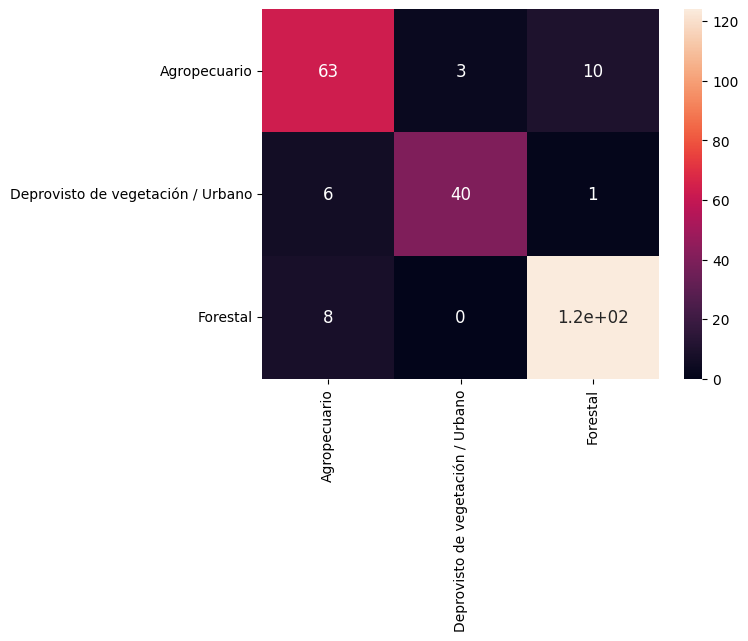

In [ ]:
# CART: Matriz de confusión, accuracy e índice Kappa
error_matrix= validacion_modelo(mosaico_2022_mun,validacion_2022,'clase_id',model_trained_cart,3)
accuracy = round(error_matrix.accuracy().getInfo(),3)
kappa = round(error_matrix.kappa().getInfo(),3)
modelos['modelo'].append(model_selected)
modelos['Accuracy'].append(accuracy)
modelos['Kappa'].append(kappa)
print(f'Con el modelo {model_selected} se obtiene un accuracy de {accuracy} y un índice de Kappa de {kappa}')
df_mc= pd.DataFrame(np.array(error_matrix.getInfo())[1:,1:],index=clases,columns=clases)
sns.heatmap(df_mc, annot=True, annot_kws={"size": 12}) # font size
plt.show()

### 9.4.2 Mapa de cobertura (CART)

In [ ]:
# CART: mapa de cobertura
lc_vis_params = {'min': 0,'max': 0.3,'bands':['B4','B3','B2']}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(mosaico_2022_mun, lc_vis_params, 'Mosaico satelital 20222')
lc_vis_params = {'min':1,'max':3,'palette':paleta_cob}
my_map.add_ee_layer(cob_cart_map_2022, lc_vis_params, f'Mapa de cobertura 2022 - {model_selected}')

my_map.add_child(folium.LayerControl())

display(my_map)

## 10. Comparación de modelos

In [ ]:
# Comparación de modelos
df_res_model = pd.DataFrame(data=modelos)
df_res_model

,modelo,Accuracy,Kappa
0,RandomForest,0.918,0.862
1,GTB,0.925,0.875
2,SVM,0.831,0.708
3,Cart,0.890,0.818


## 11. Análisis de los Resultados:

1. **RandomForest:**
   - **Accuracy:** 0.918
   - **Kappa:** 0.862
   
   **Análisis:** El modelo RandomForest tiene una alta precisión del 91.8%, lo cual indica que la mayoría de las predicciones realizadas por este modelo son correctas. El coeficiente Kappa de 0.862 sugiere que el modelo tiene un buen acuerdo entre las predicciones y las etiquetas reales. Este modelo es robusto y se desempeña bien.

2. **GTB (Gradient Boosting Trees):**
   - **Accuracy:** 0.925
   - **Kappa:** 0.875
   
   **Análisis:** El modelo GTB tiene la precisión más alta entre los cuatro modelos, con un 92.5%. Esto indica que es el más preciso en términos de predicciones correctas. El coeficiente Kappa de 0.875 también es el más alto, lo que sugiere un excelente acuerdo entre las predicciones del modelo y las etiquetas reales, superando el desempeño del RandomForest en ambos indicadores.

3. **SVM (Support Vector Machine):**
   - **Accuracy:** 0.831
   - **Kappa:** 0.708
   
   **Análisis:** El modelo SVM tiene una precisión del 83.1%, que es significativamente menor que la de los modelos RandomForest y GTB. El coeficiente Kappa de 0.708 indica un acuerdo moderado entre las predicciones y las etiquetas reales. Aunque SVM no es tan preciso ni tiene un acuerdo tan alto como los otros dos modelos mencionados anteriormente, aún puede ser útil dependiendo del contexto del problema.

4. **Cart (Classification and Regression Trees):**
   - **Accuracy:** 0.890
   - **Kappa:** 0.818
   
   **Análisis:** El modelo Cart tiene una precisión del 89.0%, situándose entre SVM y RandomForest. El coeficiente Kappa de 0.818 muestra un buen acuerdo entre las predicciones y las etiquetas reales, aunque no tan alto como GTB o RandomForest. Este modelo tiene un desempeño sólido, aunque no es el mejor en este conjunto de modelos.

### Conclusión:

- **Mejor Modelo:** GTB (Gradient Boosting Trees) es el mejor modelo en términos de precisión y coeficiente Kappa.
- **Modelos Competitivos:** RandomForest también muestra un excelente desempeño y es muy cercano al GTB.
- **Modelos Moderados:** Cart tiene un buen desempeño, aunque no es tan alto como GTB o RandomForest. SVM tiene el desempeño más bajo en este conjunto, pero todavía puede ser útil en ciertos contextos.

De acuerdo a nuestros resultados, el modelo más preciso y con el mejor acuerdo entre predicciones y etiquetas reales, GTB sería la elección recomendada.

## 12. Modelo ganador GTB - Mapa de cobertura

In [ ]:
# Modelo Ganador GTB: mapa de cobertura
lc_vis_params = {'min': 0,'max': 0.3,'bands':['B4','B3','B2']}
my_map = folium.Map(location=[lat, lon], zoom_start=10)
basemaps['Google Satellite Hybrid'].add_to(my_map)
basemaps['Google Maps'].add_to(my_map)
my_map.add_ee_layer(mosaico_2022_mun, lc_vis_params, 'Mosaico satelital 20222')
lc_vis_params = {'min':1,'max':3,'palette':paleta_cob}
my_map.add_ee_layer(cob_gtb_map_2022, lc_vis_params, f'Mapa de cobertura 2022 - {model_selected}')

my_map.add_child(folium.LayerControl())

display(my_map)

In [ ]:
#@title Exportar mapa para uso en sistemas de inforcación geográfica
import io
import requests

bbounds = ze.geometry()
l_lat,l_long = [],[]
for coords in bbounds.getInfo()['coordinates']:

  for puntos in coords:
    for punto in puntos:
        l_long.append(punto[0])
        l_lat.append(punto[1])
region = ee.Geometry.BBox(min(l_long), min(l_lat),max(l_long), max(l_lat))
url = cob_gtb_map_2022.getDownloadUrl({
    'bands': ['classification'],
    'region': region,
    'scale': 100, ## tamaño de pixel
     'crs':"EPSG:32616",
    'format': 'GEO_TIFF'
})

response = requests.get(url)
with open('cobertura_2022_utm.tif', 'wb') as fd:
  fd.write(response.content)
print("capa de cobertura TIF creada : cobertura_2022_utm.tif")

capa de cobertura TIF creada : cobertura_2022_utm.tif


In [ ]:
## Calculo de áreas de cobertura
'''
areas = cob_gtb_map_2022.eq(1).reduceRegion(reducer= ee.Reducer.sum(),geometry=ze,scale =100)
print(areas.getInfo())
areas = cob_gtb_map_2022.eq(2).reduceRegion(reducer= ee.Reducer.sum(),geometry=ze,scale =100)
print(areas.getInfo())
areas = cob_gtb_map_2022.eq(3).reduceRegion(reducer= ee.Reducer.sum(),geometry=ze,scale =100)
print(areas.getInfo())'''

'\nareas = cob_gtb_map_2022.eq(1).reduceRegion(reducer= ee.Reducer.sum(),geometry=ze,scale =100)\nprint(areas.getInfo())\nareas = cob_gtb_map_2022.eq(2).reduceRegion(reducer= ee.Reducer.sum(),geometry=ze,scale =100)\nprint(areas.getInfo())\nareas = cob_gtb_map_2022.eq(3).reduceRegion(reducer= ee.Reducer.sum(),geometry=ze,scale =100)\nprint(areas.getInfo())'

Cobertura | Área (ha)
----------|-----:
Agropecuario| 94,951
Deprovisto de vegetación / Urbano| 4,653
Forestal| 775,121

Conclusiones

A partir del programa estratégico estadounidense Corona estableido desde 1959 y 1972, que se utilizarón para la vigilancia fotográfica de la Unión Soviética, China y otras áreas, el uso de imágenes aereas y satélitales ha despeñado un papel crucial. Este programa inspiro programas como LANDSAT de EUA o SENTINEL de la UE para el monitoreo de los recursos naturales.

La constante observación de estos programas ha generado todo un historico de fotografias satélitales de los recursos  naturales y el rápido crecimiento y desarrollo en el poder de computo actual esta permitiendo que dichos datos se puedan procesar de una manera más eficiente y mas rápida

Tan solo en el año 2010 la generación de un mapa de cobertura era en exceso muy laborioso y en terminos generales, costoso, el software disponible en la epoca era en extremo altamente costoso ademas de que se requeria contar con equipos de computo de alto procesamiento (en esa época) no era tan accesible.

Hoy en día se cuenta con herramientas como Google Earth Engine, que es una plataforma de análisis geoespacial basada en la nube que permite acceder al banco de imágenes satélitales púbicos de una manera eficiente, provee una API en la cual se pueden crear algoritmos como el anterior y realizar una serie de aplicaciones.

En nuestro caso, este proyecto podria sentar las bases para un futuro trabajo en el cual se realice un análisis de cambio de cobertura, partiendo como líena base el año 2022.

Otro futuro trabajo es crear modelos de machine learning que mas alla que aprendan de los valrores perse de las bandas espectrales, aprendan el patron geométrico de distintas clases de cobertura, con el fin de entrenar y generalizar un modelo, que no sea específico de un sensor, y puedan combinarse distintos sensores y clasificar distintos años con un modelo entrenado sin la necesidad de tener los datos de entreamiento y la etiqueta correcta para el año a clasificar. de esta forma se estaria automatizando el monitoreo de los recursos y miendo el impacto humano y/o climatico.